# Load Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

# Load data and break it up into training & CV

In [2]:
df = pd.read_csv('train.csv')
print("Num examples = {}".format(df.shape[0]))

# Shuffle data as its ordered by wilderness area
df = df.sample(frac=1).reset_index(drop=True)
training = df.loc[0:12999]
cv = df.loc[13000:].reset_index()

X = training.loc[:, 'Elevation':'Soil_Type40']
Y = training['Cover_Type']
# convert to one-hot
Y = pd.get_dummies(Y)

X_cv = cv.loc[:, 'Elevation':'Soil_Type40']
Y_cv = cv['Cover_Type']
# convert to one-hot
Y_cv = pd.get_dummies(Y_cv)

print("We have split them into {} training examples and {} cross validation examples".format(training.shape[0], cv.shape[0]))
print("Number of input features: {}".format(X.shape[1]))
print("Number of output classes: {}".format(Y.shape[1]))

Num examples = 15120
We have split them into 13000 training examples and 2120 cross validation examples
Number of input features: 54
Number of output classes: 7


# Sample Data

In [3]:
X.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,2748,61,15,360,74,390,231,208,106,2331,...,0,0,0,0,0,0,0,0,0,0
1,2524,191,9,256,40,924,220,247,161,983,...,0,0,0,0,0,0,0,0,0,0
2,2763,157,22,485,129,2589,238,237,118,2083,...,0,0,0,0,0,0,0,0,0,0
3,3447,330,13,458,78,4913,188,224,175,4362,...,0,0,0,0,0,0,0,1,0,0
4,3404,108,21,301,166,3948,250,211,79,3529,...,0,0,0,0,0,0,0,0,1,0


# Normalize some features

In [4]:
def normalizeRows(rows):
    norm = np.linalg.norm(rows,axis=0, keepdims=True)
    return rows / norm

def normalizeData(X):
    X['Elevation'] = normalizeRows(X['Elevation'].values)
    X['Aspect'] = normalizeRows(X['Aspect'].values)
    X['Slope'] = normalizeRows(X['Slope'].values)
    X['Horizontal_Distance_To_Hydrology'] = normalizeRows(X['Horizontal_Distance_To_Hydrology'].values)
    X['Vertical_Distance_To_Hydrology'] = normalizeRows(X['Vertical_Distance_To_Hydrology'].values)
    X['Horizontal_Distance_To_Roadways'] = normalizeRows(X['Horizontal_Distance_To_Roadways'].values)
    X['Hillshade_9am'] = normalizeRows(X['Hillshade_9am'].values)
    X['Hillshade_Noon'] = normalizeRows(X['Hillshade_Noon'].values)
    X['Hillshade_3pm'] = normalizeRows(X['Hillshade_3pm'].values)
    X['Horizontal_Distance_To_Fire_Points'] = normalizeRows(X['Horizontal_Distance_To_Fire_Points'].values)
    return X

X = normalizeData(X.copy())
X_cv = normalizeData(X_cv.copy())

# Train simple NN

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers
from keras import regularizers
import time

def train_NN(X, Y, X_cv, Y_cv, epochs=1000, learning_rate = 0.001, lamb = 0.01, batch_size=32, hidden_layers=1, units_per_layer=32):
    model = Sequential()
    adam = optimizers.Adam(lr=learning_rate, epsilon=1E-8)
    # input layer
    model.add(Dense(units_per_layer, activation='relu', input_dim=X.shape[1], kernel_regularizer=regularizers.l2(lamb)))
    for l in range(hidden_layers-1):
        model.add(Dense(units_per_layer, activation='relu', kernel_regularizer=regularizers.l2(lamb)))
    model.add(Dense(Y.shape[1], activation='softmax'))
    model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    # Train the model, iterating on the data in batches of batch_size samples
    print ("Training model, lr: {}, lambda: {}, batch: {}, layers: {}, units/layer: {}".format(learning_rate, lamb, batch_size, hidden_layers, units_per_layer))
    start = time.time()
    history = model.fit(X, Y, epochs=epochs, batch_size=batch_size, verbose=0)
    end = time.time()
    print ("Took: {} seconds to train NN".format(end - start))
    print ("Training loss = {}, accuracy = {}".format(history.history['loss'][-1], history.history['acc'][-1]))
    score = model.evaluate(X_cv, Y_cv, batch_size=128)
    print ("CV eval, loss = {}, accuracy = {}\n\n".format(score[0], score[1]))
    return history

def plot_history(history):
    # plot the cost & accuracy
    f, axarr = plt.subplots(2, sharex=True, figsize=(12,9))
    plt.title("Cost / accuracy vs epochs")
    axarr[0].plot(history.history['loss'])
    axarr[0].set_ylabel("Cost")
    axarr[1].plot(history.history['acc'])
    axarr[1].set_ylabel("Accuracy")
    f.subplots_adjust(hspace=0.3)
    plt.show()

In [6]:
history = train_NN(X, Y, X_cv, Y_cv, epochs=100, batch_size=128, hidden_layers=5,units_per_layer=48)

Training model, lr: 0.001, batch: 128, layers: 5, units/layer: 48
Took: 32.81236720085144 seconds to train NN
Training loss = 1.1201832523345947, accuracy = 0.5611538463005653
2120/2120 [==============================] - 0s 54us/step
CV eval, loss = 1.143853678343431, accuracy = 0.5042452836936375




# Loop over various hyperparams

Training model, lr: 0.0001, batch: 128, layers: 1, units/layer: 24
Took: 186.20277309417725 seconds to train NN
Training loss = 11.40613616825984, accuracy = 0.26515384613550624
2120/2120 [==============================] - 1s 680us/step
CV eval, loss = 11.674982049330225, accuracy = 0.25235849034111457


Training model, lr: 0.0001, batch: 128, layers: 1, units/layer: 32
Took: 191.8555977344513 seconds to train NN
Training loss = 7.277287330627441, accuracy = 0.4426923077106476
2120/2120 [==============================] - 2s 796us/step
CV eval, loss = 7.2602019633886945, accuracy = 0.4514150952393154


Training model, lr: 0.0001, batch: 128, layers: 1, units/layer: 40
Took: 197.28437614440918 seconds to train NN
Training loss = 13.732619988074669, accuracy = 0.1480000000137549
2120/2120 [==============================] - 2s 823us/step
CV eval, loss = 13.898058455845096, accuracy = 0.13773584908471917


Training model, lr: 0.0001, batch: 128, layers: 2, units/layer: 24
Took: 214.51416015

Training model, lr: 0.0003, batch: 128, layers: 5, units/layer: 24
Took: 303.64634704589844 seconds to train NN
Training loss = 13.851645954425518, accuracy = 0.14061538461538461
2120/2120 [==============================] - 2s 934us/step
CV eval, loss = 13.593943462731703, accuracy = 0.15660377347244406


Training model, lr: 0.0003, batch: 128, layers: 5, units/layer: 32
Took: 309.00607109069824 seconds to train NN
Training loss = 4.888622064150296, accuracy = 0.5920769231869624
2120/2120 [==============================] - 2s 908us/step
CV eval, loss = 5.052995492827217, accuracy = 0.5712264148694164


Training model, lr: 0.0003, batch: 128, layers: 5, units/layer: 40
Took: 385.41036796569824 seconds to train NN
Training loss = 13.80329158959022, accuracy = 0.14361538461538462
2120/2120 [==============================] - 4s 2ms/step
CV eval, loss = 13.890455721009452, accuracy = 0.13820754719792672


Training model, lr: 0.001, batch: 128, layers: 1, units/layer: 24
Took: 342.4635188579

Took: 333.95451498031616 seconds to train NN
Training loss = 13.794612679114708, accuracy = 0.144153846181356
2120/2120 [==============================] - 3s 1ms/step
CV eval, loss = 13.943675843724664, accuracy = 0.1349056604054739


Training model, lr: 0.003, batch: 128, layers: 4, units/layer: 32
Took: 339.9160590171814 seconds to train NN
Training loss = 13.802051810044508, accuracy = 0.1436923076923077
2120/2120 [==============================] - 4s 2ms/step
CV eval, loss = 13.898058463042638, accuracy = 0.13773584911283457


Training model, lr: 0.003, batch: 128, layers: 4, units/layer: 40
Took: 345.3337469100952 seconds to train NN
Training loss = 13.844206827016977, accuracy = 0.14107692308609301
2120/2120 [==============================] - 3s 1ms/step
CV eval, loss = 13.639560627487471, accuracy = 0.15377358484942957


Training model, lr: 0.003, batch: 128, layers: 5, units/layer: 24
Took: 368.50499296188354 seconds to train NN
Training loss = 13.811970574599046, accuracy = 0.

2120/2120 [==============================] - 3s 2ms/step
CV eval, loss = 13.90566137421806, accuracy = 0.13726415083093463


Training model, lr: 0.03, batch: 128, layers: 3, units/layer: 32
Took: 391.7035632133484 seconds to train NN
Training loss = 13.811970558166504, accuracy = 0.14307692307692307
2120/2120 [==============================] - 3s 2ms/step
CV eval, loss = 13.837235295997475, accuracy = 0.14150943413095654


Training model, lr: 0.03, batch: 128, layers: 3, units/layer: 40
Took: 395.3022379875183 seconds to train NN
Training loss = 13.844206855773926, accuracy = 0.1410769230585832
2120/2120 [==============================] - 4s 2ms/step
CV eval, loss = 13.639560627487471, accuracy = 0.15377358484942957


Training model, lr: 0.03, batch: 128, layers: 4, units/layer: 24
Took: 407.1627628803253 seconds to train NN
Training loss = 13.800811915471003, accuracy = 0.14376923078757067
2120/2120 [==============================] - 3s 2ms/step
CV eval, loss = 13.90566137421806, accu

Training model, lr: 0.3, batch: 128, layers: 2, units/layer: 32
Took: 471.0549421310425 seconds to train NN
Training loss = 13.802051807110127, accuracy = 0.14369230770147765
2120/2120 [==============================] - 7s 3ms/step
CV eval, loss = 13.898058463042638, accuracy = 0.13773584911283457


Training model, lr: 0.3, batch: 128, layers: 2, units/layer: 40
Took: 473.9725971221924 seconds to train NN
Training loss = 13.79461263333834, accuracy = 0.14415384619052593
2120/2120 [==============================] - 6s 3ms/step
CV eval, loss = 13.943675843724664, accuracy = 0.1349056604054739


Training model, lr: 0.3, batch: 128, layers: 3, units/layer: 24
Took: 485.6039559841156 seconds to train NN
Training loss = 13.803291648864747, accuracy = 0.14361538460621467
2120/2120 [==============================] - 7s 3ms/step
CV eval, loss = 13.890455721009452, accuracy = 0.13820754719792672


Training model, lr: 0.3, batch: 128, layers: 3, units/layer: 32
Took: 491.1684169769287 seconds to 

2120/2120 [==============================] - 13s 6ms/step
CV eval, loss = 13.943675843724664, accuracy = 0.1349056604054739


Training model, lr: 3.0, batch: 128, layers: 1, units/layer: 40
Took: 667.8104610443115 seconds to train NN
Training loss = 13.851645991985615, accuracy = 0.14061538461538461
2120/2120 [==============================] - 9s 4ms/step
CV eval, loss = 13.593943462731703, accuracy = 0.15660377347244406


Training model, lr: 3.0, batch: 128, layers: 2, units/layer: 24
Took: 558.6989691257477 seconds to train NN
Training loss = 13.802051788330077, accuracy = 0.14369230770147765
2120/2120 [==============================] - 8s 4ms/step
CV eval, loss = 13.898058463042638, accuracy = 0.13773584911283457


Training model, lr: 3.0, batch: 128, layers: 2, units/layer: 32
Took: 563.1871619224548 seconds to train NN
Training loss = 13.851645979661209, accuracy = 0.14061538462455456
2120/2120 [==============================] - 8s 4ms/step
CV eval, loss = 13.593943462731703, accu

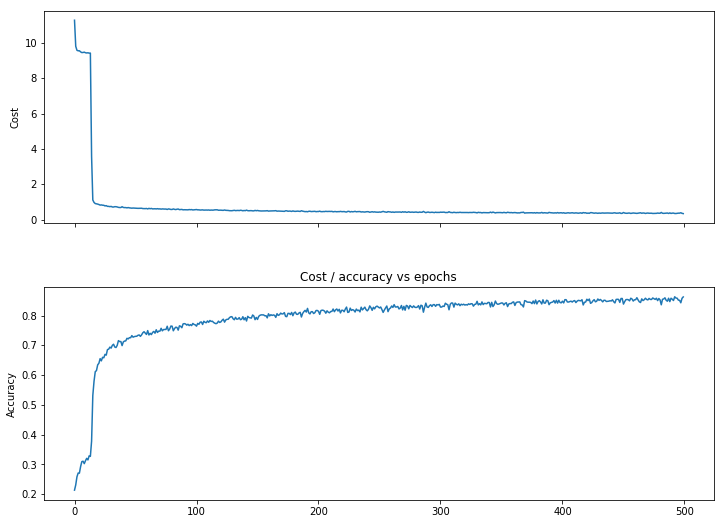

In [168]:
best_historic_loss = 100000.0
best_params = ()
best_history = []
for lr in [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0]:
    for layer in range(1, 6):
        for units in [24, 32, 40]:
            history = train_NN(X, Y, X_cv, Y_cv, epochs=500, learning_rate=lr, batch_size=128, hidden_layers=layer,units_per_layer=units)
            if (history.history['loss'][-1] < best_historic_loss):
                best_historic_loss = history.history['loss'][-1]
                best_params = (lr, layer, units)
                best_history = history

print("Best params: learningRate = {}, layers = {}, units/layer = {}".format(best_params[0], best_params[1], best_params[2]))
plot_history(best_history)

# Train best configuration

In [171]:
history = train_NN(X, Y, X_cv, Y_cv, epochs=10000, learning_rate=0.001, batch_size=128, hidden_layers=5,units_per_layer=40)

Training model, lr: 0.001, batch: 128, layers: 5, units/layer: 40
Took: 1386.059611082077 seconds to train NN
Training loss = 0.23859386148819556, accuracy = 0.907153846190526
2120/2120 [==============================] - 12s 6ms/step
CV eval, loss = 0.5791958302821754, accuracy = 0.8273584907909609




Training model, lr: 0.0003, batch: 128, layers: 4, units/layer: 40
Took: 295.9254517555237 seconds to train NN
Training loss = 1.0463292142427885, accuracy = 0.5883076923076923
2120/2120 [==============================] - 0s 91us/step
CV eval, loss = 1.0290852942556705, accuracy = 0.6132075471698113


Training model, lr: 0.001, batch: 128, layers: 4, units/layer: 40
Took: 306.9148406982422 seconds to train NN
Training loss = 1.0294787177305955, accuracy = 0.5876923075455885
2120/2120 [==============================] - 0s 97us/step
CV eval, loss = 1.0160383096281087, accuracy = 0.6000000002249232


Training model, lr: 0.001, batch: 128, layers: 5, units/layer: 40
Took: 348.245609998703 seconds to train NN
Training loss = 1.048413741845351, accuracy = 0.5880769232236422
2120/2120 [==============================] - 0s 130us/step
CV eval, loss = 1.0313214769903218, accuracy = 0.6028301891290917


Best params: learningRate = 0.001, layers = 4, units/layer = 40


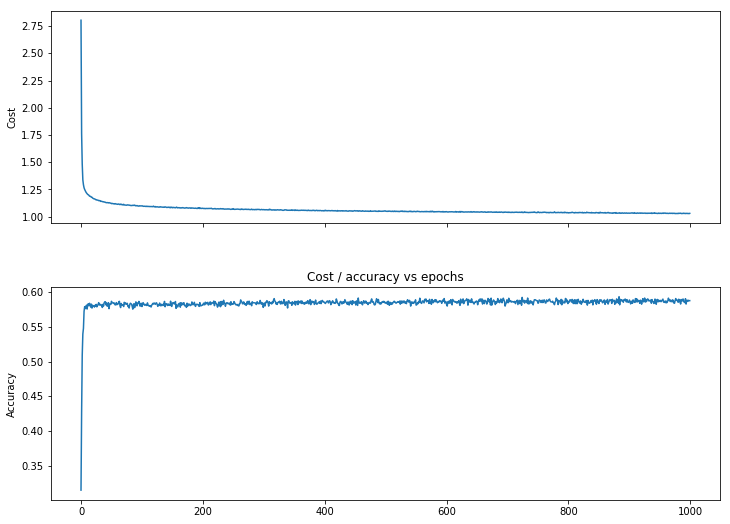

In [8]:
best_historic_loss = 100000.0
best_params = ()
best_history = []
for config in [ (0.0003, 128, 4, 40), (0.001, 128, 4, 40), (0.001, 128, 5, 40) ]:
  history = train_NN(X, Y, X_cv, Y_cv, epochs=1000, learning_rate=config[0], batch_size=128, hidden_layers=config[2],units_per_layer=config[3])
  if (history.history['loss'][-1] < best_historic_loss):
    best_historic_loss = history.history['loss'][-1]
    best_params = (config[0], config[2], config[3])
    best_history = history

print("Best params: learningRate = {}, layers = {}, units/layer = {}".format(best_params[0], best_params[1], best_params[2]))
plot_history(best_history)

# Try out different lambda values

Training model, lr: 0.001, lambda: 0.0001, batch: 128, layers: 4, units/layer: 40
Took: 335.6865997314453 seconds to train NN
Training loss = 0.6007259249320397, accuracy = 0.7890000000366798
2120/2120 [==============================] - 0s 233us/step
CV eval, loss = 9.79655958571524, accuracy = 0.21367924573286523


Training model, lr: 0.001, lambda: 0.0003, batch: 128, layers: 4, units/layer: 40
Took: 351.00606203079224 seconds to train NN
Training loss = 0.7415684920090896, accuracy = 0.7158461538828337
2120/2120 [==============================] - 1s 255us/step
CV eval, loss = 8.038661811036883, accuracy = 0.22924528290640633


Training model, lr: 0.001, lambda: 0.001, batch: 128, layers: 4, units/layer: 40
Took: 383.5112991333008 seconds to train NN
Training loss = 0.8678551511030931, accuracy = 0.6490769229302039
2120/2120 [==============================] - 1s 288us/step
CV eval, loss = 1.9024869302533707, accuracy = 0.43443396136445817


Training model, lr: 0.001, lambda: 0.003, b

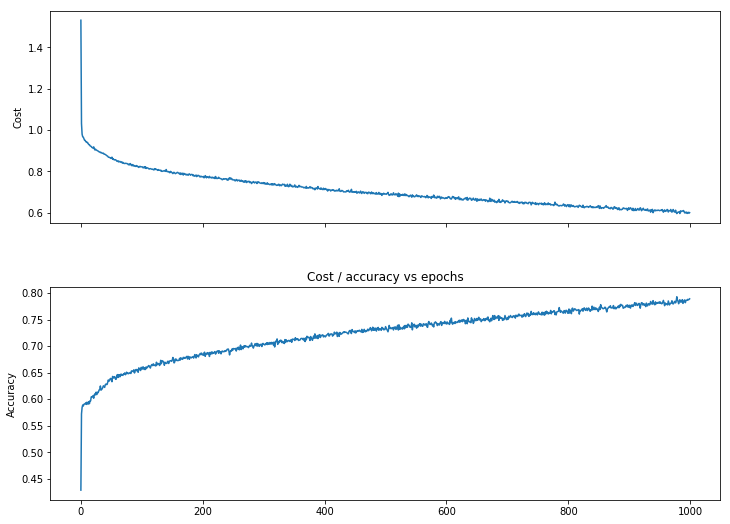

In [14]:
best_historic_loss = 100000.0
best_lambda = 0.0
best_history = []
for lamb in [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0]:
  history = train_NN(X, Y, X_cv, Y_cv, epochs=1000, learning_rate=0.001, lamb = lamb, batch_size=128, hidden_layers=4,units_per_layer=40)
  if (history.history['loss'][-1] < best_historic_loss):
    best_historic_loss = history.history['loss'][-1]
    best_lamb = lamb
    best_history = history  

print("Best lambda:  {}".format(best_lambda))
plot_history(best_history)

# Try super deep NN

Training model, lr: 0.001, lambda: 0.01, batch: 128, layers: 20, units/layer: 200
Took: 424.45785903930664 seconds to train NN
Training loss = 1.9459591853068425, accuracy = 0.14476923076923076
2120/2120 [==============================] - 2s 818us/step
CV eval, loss = 1.946193155702555, accuracy = 0.1311320755841597




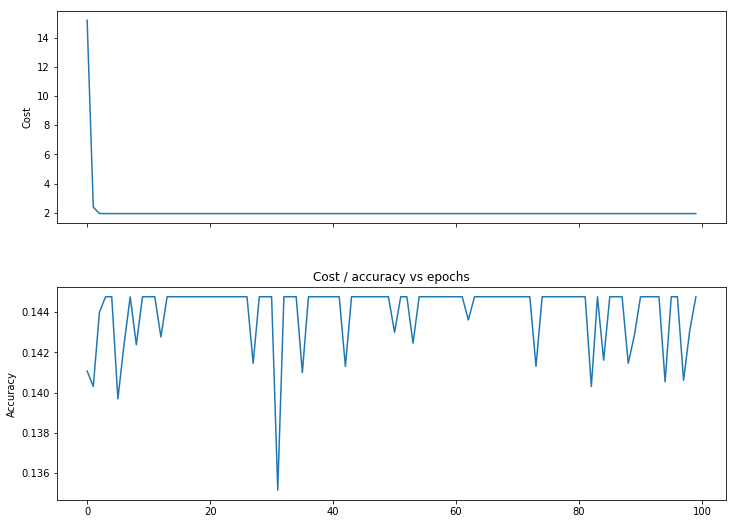

In [18]:
history = train_NN(X, Y, X_cv, Y_cv, epochs=100, learning_rate=0.001, lamb = 0.01, batch_size=128, hidden_layers=10,units_per_layer=100)
plot_history(history)

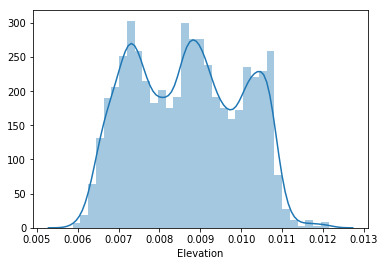

In [71]:
sns.distplot(X['Elevation'])

In [4]:
# df['Wilderness_Area'] = df[['Wilderness_Area1','Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4']].idxmax(axis=1).apply(lambda x: int(x.replace('Wilderness_Area', '')))

# df['Soil_Type'] = df[['Soil_Type{}'.format(i) for i in range(1, 41)]].idxmax(axis=1).apply(lambda x: int(x.replace('Soil_Type', '')))

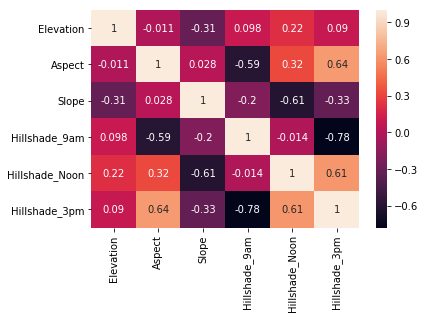

In [6]:
df = (
    df.loc[:, ['Elevation', 'Aspect', 'Slope', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']]
).corr()

sns.heatmap(df, annot=True)

In [8]:
df.shape

(6, 6)